## Missing Data Examples

In this notebook we will look at the effects missing data can have on conclusions you can draw from data.  We will also go over some practical implementations for linear regressions in Python

In [1]:
# Includes and Standard Magic...
### Standard Magic and startup initializers.

# Load Numpy
import numpy as np
# Load MatPlotLib
import matplotlib
import matplotlib.pyplot as plt
# Load Pandas
import pandas as pd
# Load SQLITE
import sqlite3
# Load Stats
from scipy import stats

# This lets us show plots inline and also save PDF plots if we want them
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
matplotlib.style.use('fivethirtyeight')

# These two things are for Pandas, it widens the notebook and lets us display data easily.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Show a ludicrus number of rows and columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

For this work we will be using data from: Generalized body composition prediction equation for men using simple measurement techniques", K.W. Penrose, A.G. Nelson, A.G. Fisher, FACSM, Human Performance research Center, Brigham Young University, Provo, Utah 84602 as listed in Medicine and Science in Sports and Exercise, vol. 17, no. 2, April 1985, p. 189.

[Data availabe here.](http://staff.pubhealth.ku.dk/~tag/Teaching/share/data/Bodyfat.html)


In [2]:
# Load the Penrose Data
df_penrose = pd.read_csv("./data/bodyfat.csv")

In [3]:
display(df_penrose.head())
# observations = ['Neck', 'Chest', 'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist']
observations = ['Age', 'Neck', 'Forearm', 'Wrist']

,Density,bodyfat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [4]:
len(df_penrose)

252

Let's do some basic scatter plots first to see what's going on.

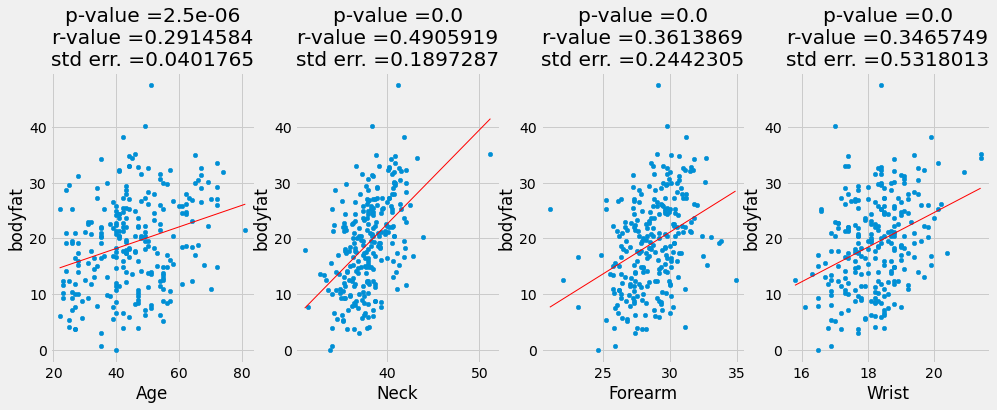

In [5]:
# Let's do a basic Linear Regression on a Single Variable.
# Note that linregress p-value is whether or not the slope is 0, not if the correlation is significant.
fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,o in enumerate(observations):
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_penrose[o],
                                                                   df_penrose['bodyfat'])

    # Pack these into a nice title
    diag_str = "p-value =" + str(round(p_value, 7)) + "\n" + "r-value =" + str(round(r_value, 7)) + "\nstd err. =" + str(round(std_err, 7))
    df_penrose.plot.scatter(x=o, y='bodyfat', title=diag_str, ax=ax[i])
    
    # Make points and line
    pts = np.linspace(df_penrose[o].min(), df_penrose[o].max(), 500)
    line = slope * pts + intercept
    ax[i].plot(pts, line, lw=1, color='red')
    
    

What happens if we start to remove parts of the data -- is the relationship still as strong?

We can use the [pandas sample command](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) to remove some of the dataframe.

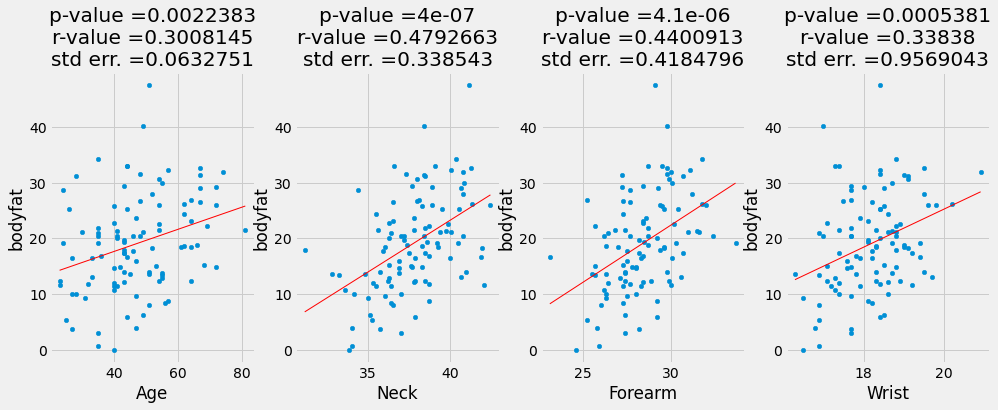

In [7]:
# Let's do a basic Linear Regression on a Single Variable.
# Note that linregress p-value for the null-hyp that slope = 0.
df_test = df_penrose.sample(frac=0.40, replace=False)

fig, ax = plt.subplots(1, 4, figsize=(15,5))
for i,o in enumerate(observations):
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_test[o],
                                                                   df_test['bodyfat'])

    # Pack these into a nice title
    diag_str = "p-value =" + str(round(p_value, 7)) + "\n" + "r-value =" + str(round(r_value, 7)) + "\nstd err. =" + str(round(std_err, 7))
    df_test.plot.scatter(x=o, y='bodyfat', title=diag_str, ax=ax[i])
    
    # Make points and line
    pts = np.linspace(df_test[o].min(), df_test[o].max(), 500)
    line = slope * pts + intercept
    ax[i].plot(pts, line, lw=1, color='red')
    
    


If we want to determine if these correlations are significant under the missing data then we need to run bootstrap samples and see what happens.



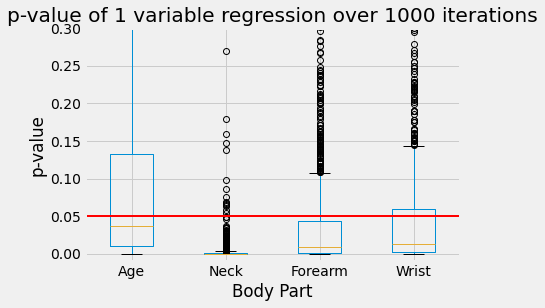

In [9]:
results = {o:[] for o in observations}
bootstrap_samples = 1000
fraction = 0.20

for i,o in enumerate(observations):
    for t in range(bootstrap_samples):
        df_test = df_penrose.sample(frac=fraction, replace=False)
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_test[o],df_test['bodyfat'])
        #r,p = stats.pearsonr(df_test[o], df_test['bodyfat'])
        results[o].append(p_value)
        
rs = pd.DataFrame(results)
ax = rs.boxplot()
ax.set_ylim([-0.01,0.30])
ax.set_title(f"p-value of 1 variable regression over {bootstrap_samples} iterations")
ax.set_ylabel("p-value")
ax.set_xlabel("Body Part")
ax.axhline(y=0.05, lw=2, color='red')
plt.show()

As we can see above as we run more and more samples and plot the p-values